In [1]:
import pandas as pd #导入Pandas
df_sales = pd.read_csv('电商历史订单.csv') #载入数据
df_sales.head() #显示头几行数据 

,订单号,产品码,消费日期,产品说明,数量,单价,用户码,城市
0,536374,21258,6/1/2022 9:09,绿联usb分线器 一拖四,32,10.95,15100,北京
1,536376,22114,6/1/2022 9:32,加大男装T恤男大码胖子宽松卡,48,50.45,15291,上海
2,536376,21733,6/1/2022 9:32,唐装男夏季青年棉麻中国风加肥,64,86.55,15291,上海
3,536378,22386,6/1/2022 9:37,越南进口白心火龙果4个装,10,108.95,14688,北京
4,536378,85099C,6/1/2022 9:37,大连美早樱桃400g 果径约26mm,10,166.95,14688,北京


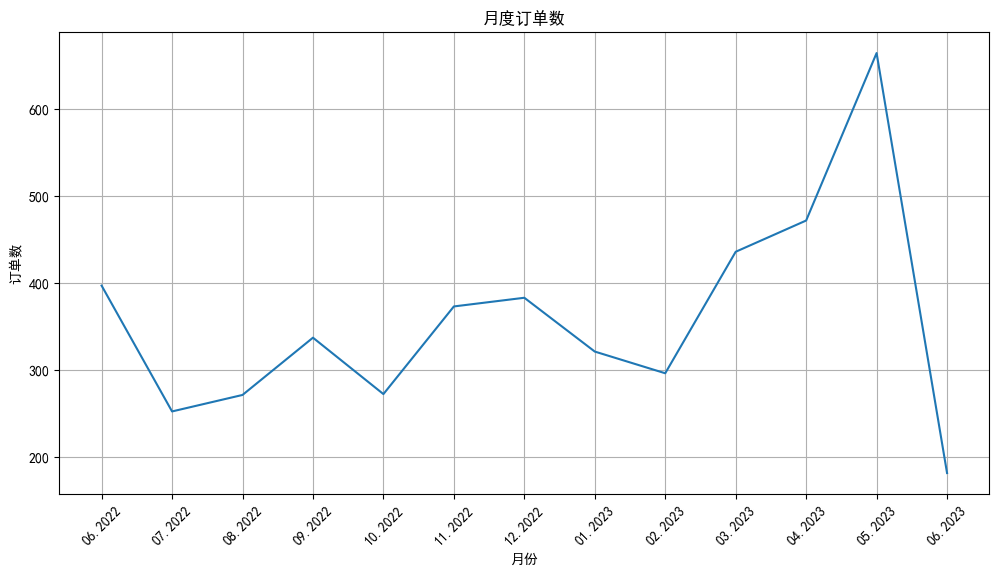

In [2]:
import matplotlib.pyplot as plt #导入Matplotlib的pyplot模块
# 设置字体为SimHei，以正常显示中文标签
plt.rcParams["font.family"]=['SimHei'] 
plt.rcParams['font.sans-serif']=['SimHei'] 
# 用来正常显示负号
plt.rcParams['axes.unicode_minus'] = False
#构建月度的订单数的DataFrame
df_sales['消费日期'] = pd.to_datetime(df_sales['消费日期']) #转化日期格式
df_orders_monthly = df_sales.set_index('消费日期')['订单号'].resample('M').nunique()
#设定绘图的画布
ax = pd.DataFrame(df_orders_monthly.values).plot(grid=True,figsize=(12,6),legend=False)
ax.set_xlabel('月份') # X轴label
ax.set_ylabel('订单数') # Y轴Label
ax.set_title('月度订单数') # 图题
#设定X轴月份显示格式
plt.xticks(
    range(len(df_orders_monthly.index)), 
    [x.strftime('%m.%Y') for x in df_orders_monthly.index], 
    rotation=45)
plt.show() # 绘图

In [3]:
df_sales = df_sales.drop_duplicates() #删除重复的数据行
df_sales = df_sales.loc[df_sales['数量'] > 0] #清洗掉数量小于等于0的数据

## 计算并添加总价信息

In [4]:
df_sales['总价'] = df_sales['数量'] * df_sales['单价'] #计算每单的总价
df_sales.head() #显示头几行数据 

,订单号,产品码,消费日期,产品说明,数量,单价,用户码,城市,总价
0,536374,21258,2022-06-01 09:09:00,绿联usb分线器 一拖四,32,10.95,15100,北京,350.4
1,536376,22114,2022-06-01 09:32:00,加大男装T恤男大码胖子宽松卡,48,50.45,15291,上海,2421.6
2,536376,21733,2022-06-01 09:32:00,唐装男夏季青年棉麻中国风加肥,64,86.55,15291,上海,5539.2
3,536378,22386,2022-06-01 09:37:00,越南进口白心火龙果4个装,10,108.95,14688,北京,1089.5
4,536378,85099C,2022-06-01 09:37:00,大连美早樱桃400g 果径约26mm,10,166.95,14688,北京,1669.5


## 构建用户表

In [5]:
df_user = pd.DataFrame(df_sales['用户码'].unique()) #生成以用户码为主键的结构df_user
df_user.columns = ['用户码'] #设定字段名
df_user = df_user.sort_values(by='用户码',ascending=True).reset_index(drop=True) #按用户码排序
df_user #显示df_user

,用户码
0,14681
1,14682
2,14684
3,14687
4,14688
...,...
975,16015
976,16016
977,16017
978,16018


## 为每个用户求出RMF值

In [6]:
df_sales['消费日期'] = pd.to_datetime(df_sales['消费日期']) #转化日期格式
df_recent_buy = df_sales.groupby('用户码').消费日期.max().reset_index() #构建消费日期信息
df_recent_buy.columns = ['用户码','最近日期'] #设定字段名
df_recent_buy['R值'] = (df_recent_buy['最近日期'].max() - df_recent_buy['最近日期']).dt.days #计算最新日期与上次消费日期的天数
df_user = pd.merge(df_user, df_recent_buy[['用户码','R值']], on='用户码') #把上次消费距最新日期的天数（R值）合并至df_user结构
df_user.head() #显示df_user头几行数据

,用户码,R值
0,14681,70
1,14682,187
2,14684,25
3,14687,106
4,14688,7


In [7]:
df_frequency = df_sales.groupby('用户码').消费日期.count().reset_index() #计算每个用户消费次数，构建df_frequency对象
df_frequency.columns = ['用户码','F值'] #设定字段名称
df_user = pd.merge(df_user, df_frequency, on='用户码') #把消费频率整合至df_user结构
df_user.head() #显示头几行数据

,用户码,R值,F值
0,14681,70,7
1,14682,187,2
2,14684,25,390
3,14687,106,15
4,14688,7,327


In [8]:
df_revenue = df_sales.groupby('用户码').总价.sum().reset_index() #根据消费总额，构建df_revenue对象
df_revenue.columns = ['用户码','M值'] #设定字段名称
df_user = pd.merge(df_user, df_revenue, on='用户码') #把消费金额整合至df_user结构
df_user.head() #显示头几行数据

,用户码,R值,F值,M值
0,14681,70,7,498.95
1,14682,187,2,52.00
2,14684,25,390,1201.51
3,14687,106,15,628.38
4,14688,7,327,18807.60


<Axes: title={'center': '消费金额分布直方图'}, ylabel='Frequency'>

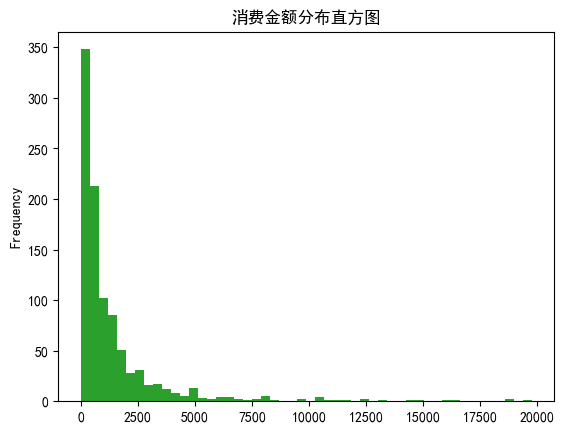

In [9]:
df_user['R值'].plot(kind='hist', bins=20, title = '新进度分布直方图') #R值直方图
df_user.query('F值 < 800')['F值'].plot(kind='hist', bins=50, title = '消费频率分布直方图') #F值直方图
df_user.query('M值 < 20000')['M值'].plot(kind='hist', bins=50, title = '消费金额分布直方图') #M值直方图

C:\Users\huangj2.ARES\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\huangj2.ARES\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\huangj2.ARES\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\huangj2.ARES\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when the

C:\Users\huangj2.ARES\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\huangj2.ARES\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\huangj2.ARES\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\huangj2.ARES\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when the

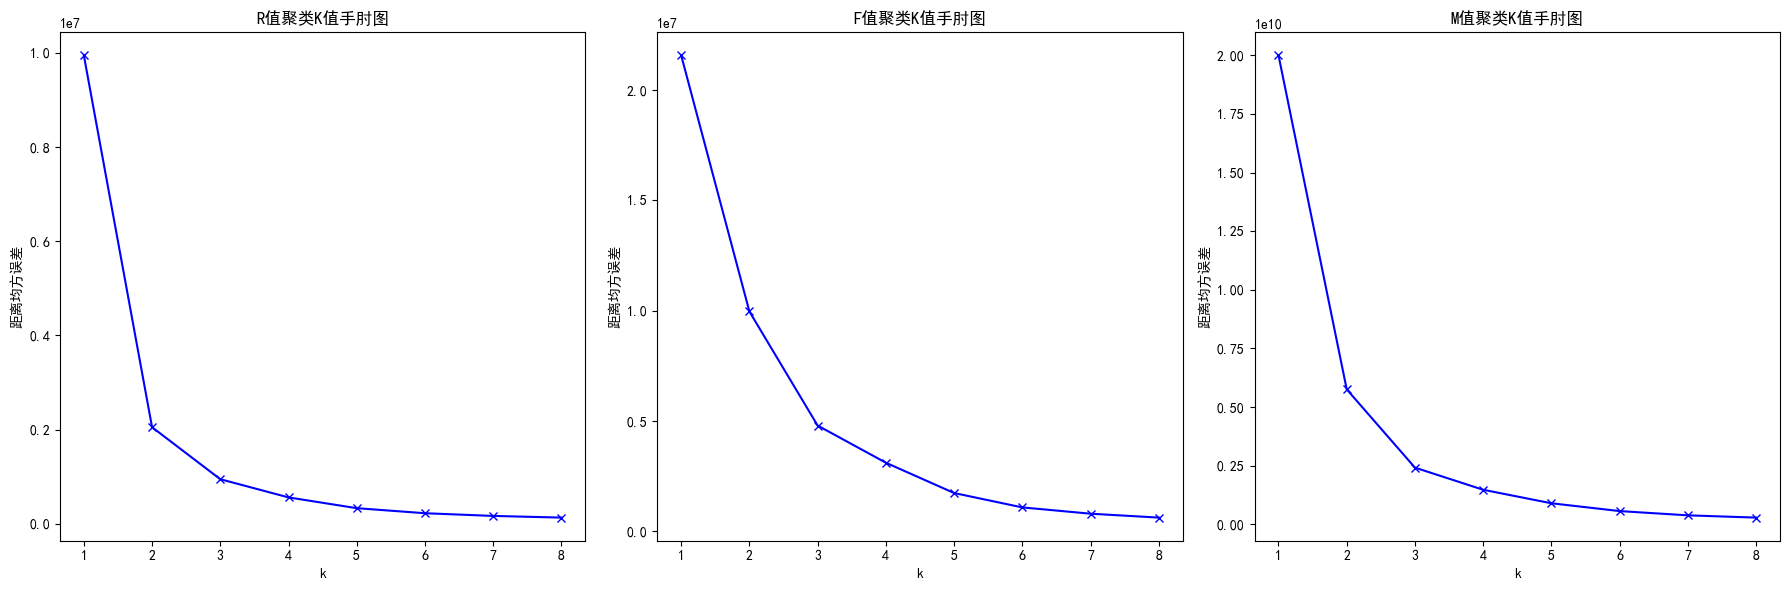

In [10]:
from sklearn.cluster import KMeans #导入KMeans模块
def show_elbow(df, ax, title): 
    distance_list = [] 
    K = range(1,9)
    for k in K:
        kmeans = KMeans(n_clusters=k, max_iter=100)
        kmeans = kmeans.fit(df)
        distance_list.append(kmeans.inertia_)
    ax.plot(K, distance_list, 'bx-')
    ax.set_xlabel('k')
    ax.set_ylabel('距离均方误差')
    ax.set_title(title)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

show_elbow(df_user[['R值']], axes[0], 'R值聚类K值手肘图')
show_elbow(df_user[['F值']], axes[1], 'F值聚类K值手肘图')
show_elbow(df_user[['M值']], axes[2], 'M值聚类K值手肘图')

plt.tight_layout()
plt.show()


## 创建和训练模型

In [11]:
from sklearn.cluster import KMeans #导入KMeans模块
kmeans_R = KMeans(n_clusters=3) #设定K=3
kmeans_F = KMeans(n_clusters=4) #设定K=4
kmeans_M = KMeans(n_clusters=4) #设定K=4

In [12]:
kmeans_R.fit(df_user[['R值']]) #拟合模型
kmeans_F.fit(df_user[['F值']]) #拟合模型
kmeans_M.fit(df_user[['M值']]) #拟合模型

C:\Users\huangj2.ARES\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\huangj2.ARES\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\huangj2.ARES\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\huangj2.ARES\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when the

KMeans(n_clusters=4)

In [13]:
df_user['R值层级'] = kmeans_R.predict(df_user[['R值']]) #通过聚类模型求出R值的层级
df_user['F值层级'] = kmeans_F.predict(df_user[['F值']]) #通过聚类模型求出F值的层级
df_user['M值层级'] = kmeans_M.predict(df_user[['M值']]) #通过聚类模型求出M值的层级
df_user.head() #显示头几行数据

,用户码,R值,F值,M值,R值层级,F值层级,M值层级
0,14681,70,7,498.95,0,0,0
1,14682,187,2,52.00,2,0,0
2,14684,25,390,1201.51,0,2,0
3,14687,106,15,628.38,2,0,0
4,14688,7,327,18807.60,0,2,2


## 给聚类后的层级排序

In [14]:
#定义一个order_cluster函数为聚类排序
def order_cluster(cluster_name, target_name,df,ascending=False):
    new_cluster_name = 'new_' + cluster_name #新的聚类名称
    df_new = df.groupby(cluster_name)[target_name].mean().reset_index() #按聚类结果分组，创建df_new对象
    df_new = df_new.sort_values(by=target_name,ascending=ascending).reset_index(drop=True) #排序
    df_new['index'] = df_new.index #创建索引字段
    df_new = pd.merge(df,df_new[[cluster_name,'index']], on=cluster_name) #基于聚类名称把df_new还原为df对象，并添加索引字段
    df_new = df_new.drop([cluster_name],axis=1) #删除聚类名称
    df_new = df_new.rename(columns={"index":cluster_name}) #将索引字段重命名为聚类名称字段
    return df_new #返回排序后的df_new对象

In [15]:
df_user = order_cluster('R值层级', 'R值', df_user, False) #调用簇排序函数
df_user = order_cluster('F值层级', 'F值', df_user, True) #调用簇排序函数
df_user = order_cluster('M值层级', 'M值', df_user, True) #调用簇排序函数
df_user = df_user.sort_values(by='用户码',ascending=True).reset_index(drop=True) #根据用户码排序
df_user.head() #显示头几行数据

,用户码,R值,F值,M值,R值层级,F值层级,M值层级
0,14681,70,7,498.95,2,0,0
1,14682,187,2,52.00,1,0,0
2,14684,25,390,1201.51,2,2,0
3,14687,106,15,628.38,1,0,0
4,14688,7,327,18807.60,2,2,2


## 为用户整体分组画像

In [16]:
df_user['总分'] = df_user['R值层级'] + df_user['F值层级'] + df_user['M值层级'] #求出每个用户RFM总分
#在df_user对象中添加总体价值这个字段
df_user.loc[(df_user['总分']<=2) & (df_user['总分']>=0), '总体价值'] = '低价值' 
df_user.loc[(df_user['总分']<=4) & (df_user['总分']>=3), '总体价值'] = '中价值' 
df_user.loc[(df_user['总分']<=8) & (df_user['总分']>=5), '总体价值'] = '高价值'
df_user #显示df_user

,用户码,R值,F值,M值,R值层级,F值层级,M值层级,总分,总体价值
0,14681,70,7,498.95,2,0,0,2,低价值
1,14682,187,2,52.00,1,0,0,1,低价值
2,14684,25,390,1201.51,2,2,0,4,中价值
3,14687,106,15,628.38,1,0,0,1,低价值
4,14688,7,327,18807.60,2,2,2,6,高价值
...,...,...,...,...,...,...,...,...,...
975,16015,3,181,704.55,2,1,0,3,中价值
976,16016,2,224,1465.51,2,1,0,3,中价值
977,16017,46,32,211.88,2,0,0,2,低价值
978,16018,38,28,408.90,2,0,0,2,低价值


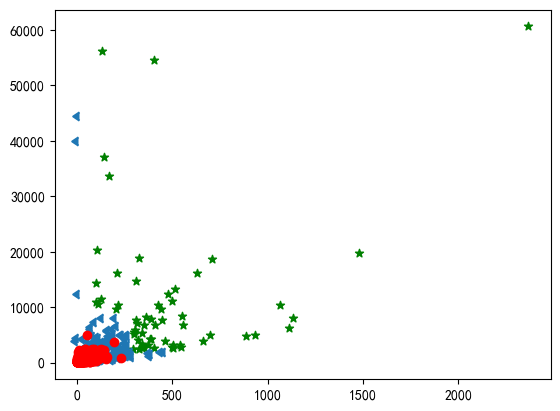

In [17]:
#显示高、中、低价值组分布散点图（F值与M值）
plt.scatter(df_user.query("总体价值 == '高价值'")['F值'],
                   df_user.query("总体价值 == '高价值'")['M值'],c='g',marker='*')
plt.scatter(df_user.query("总体价值 == '中价值'")['F值'],
                   df_user.query("总体价值 == '中价值'")['M值'],marker=8)
plt.scatter(df_user.query("总体价值 == '低价值'")['F值'],
                   df_user.query("总体价值 == '低价值'")['M值'],c='r')

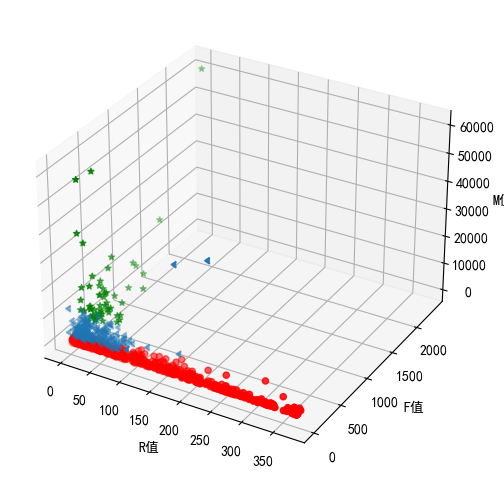

In [18]:
plt.figure(figsize=(6,6)) # 图片大小
ax = plt.subplot(111, projection='3d') # 坐标系
ax.scatter(df_user.query("总体价值 == '高价值'")['R值'], # 散点图
df_user.query("总体价值 == '高价值'")['F值'],
df_user.query("总体价值 == '高价值'")['M值'], c='g',marker='*')
ax.scatter(df_user.query("总体价值 == '中价值'")['R值'],
df_user.query("总体价值 == '中价值'")['F值'],
df_user.query("总体价值 == '中价值'")['M值'], marker=8)
ax.scatter(df_user.query("总体价值 == '低价值'")['R值'],
df_user.query("总体价值 == '低价值'")['F值'],
df_user.query("总体价值 == '低价值'")['M值'], c='r')
ax.set_xlabel('R值') # 坐标轴
ax.set_ylabel('F值') # 坐标轴
ax.set_zlabel('M值') # 坐标轴
plt.show() # 输出